# Classify Anime Characters with Fine-tuning Model
※このNotebookは、[mitmul/chainer-handson/animeface-character/classify_characters.ipynb](https://github.com/mitmul/chainer-handson/blob/master/animeface-character/classify_characters.ipynb)を元に作成しています。

このNotebookでは、animeface-characterデータセットを使ってIllustration2VecモデルをFine-tuningし、146種類のキャラクター顔画像を90%以上の精度で分類できるモデルを訓練する手順を追いながら、以下のことを説明します。

Chainerを使って

- データセットオブジェクトを作る方法
- データセットを訓練用・検証用に分割する方法
- 訓練済み重みを持ってきて新しいタスクでFine-tuningする方法
- （おまけ：データセットクラスをフルスクラッチで書く方法）

### ざっくり内容をまとめると

**Chainerに予め用意されていないデータセットを外部から調達して**、Chainerで記述されたネットワークの訓練のために用いる方法を具体例をもって示します。基本的な手順はほぼ[Chainer v4: ビギナー向けチュートリアル](https://qiita.com/mitmul/items/1e35fba085eb07a92560)で説明したCIFAR10データセットクラスを拡張する章と変わりません。

今回は、**ターゲットとなるデータと似たドメインのデータセットを用いて予め訓練されたネットワーク重みを初期値として用いる方法**を説明します。Caffeの.caffemodelの形で配布されているネットワークをFine-tuningしたい場合、この記事とほぼ同様の手順が適用できると思います。

まずは、以下のセルを実行して、ChainerとそのGPUバックエンドであるCuPyをインストールします。Colaboratoryの「ランタイムのタイプ」がGPUであれば、GPUをバックエンドとしてChainerを動かすことができます。

In [1]:
!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install -q cupy-cuda80 chainer

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libcusparse8.0 libnvrtc8.0 libnvtoolsext1
0 upgraded, 3 newly installed, 0 to remove and 0 not upgraded.
Need to get 28.9 MB of archives.
After this operation, 71.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libcusparse8.0 amd64 8.0.61-1 [22.6 MB]
Get:2 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvrtc8.0 amd64 8.0.61-1 [6,225 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvtoolsext1 amd64 8.0.61-1 [32.2 kB]
Fetched 28.9 MB in 2s (12.8 MB/s)

78Selecting previously unselected package libcusparse8.0:amd64.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../libcusparse8.0_8.0.61-1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  6%] [###..

chainerを``import``し、その後にChainerのバージョンやNumPy・CuPy、そしてCuda等の実行環境を確認してみましょう。

In [2]:
import chainer


chainer.print_runtime_info()

Chainer: 4.4.0
NumPy: 1.14.5
CuPy:
  CuPy Version          : 4.4.0
  CUDA Root             : None
  CUDA Build Version    : 8000
  CUDA Driver Version   : 9000
  CUDA Runtime Version  : 8000
  cuDNN Build Version   : 7102
  cuDNN Version         : 7102
  NCCL Build Version    : 2213


使用するライブラリをpipで入れます。

In [3]:
%%bash
pip install Pillow
pip install dill

  Running setup.py bdist_wheel for dill: started
  Running setup.py bdist_wheel for dill: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/e2/5d/17/f87cb7751896ac629b435a8696f83ee75b11029f5d6f6bda72
Successfully built dill


## 1. データセットのダウンロード

まずは、データセットをダウンロードしてきます。今回は、Kaggle Grand Masterであらせられるnagadomiさんが[こちら](http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/)で配布されているアニメキャラクターの顔領域サムネイルデータセットを使用します。

In [4]:
%%bash
if [ ! -d animeface-character-dataset ]; then
    curl -L -O http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/data/animeface-character-dataset.zip
    unzip -q animeface-character-dataset.zip
    rm -rf animeface-character-dataset.zip
fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  564M  100  564M    0     0   9.9M      0  0:00:57  0:00:57 --:--:-- 5162k


## 2. 問題設定の確認

今回は、animeface-character-datasetに含まれる様々なキャラクターの顔画像を用いて、未知のキャラクター顔画像が入力された際に、それが既知のクラス一覧の中のどのキャラクターの顔らしいかを出力するようなネットワークを訓練したいと思います。

その際に、**ランダムにパラメータを初期化したネットワークを訓練するのではなく、予め似たドメインのデータで訓練済みのモデルをベースに、目的のデータセットでFine-tuningする**というやり方をしてみます。

今回学習に用いるデータセットは、以下のような画像を多数含むデータセットで、各キャラクターごとに予めフォルダ分けがされています。なので、今回もオーソドックスな画像分類問題となります。

#### 適当に抜き出したデータサンプル

| 000_hatsune_miku | 002_suzumiya_haruhi | 007_nagato_yuki | 012_asahina_mikuru |
|:-:|:-:|:-:|:-:|
| ![face_128_326_108.png](https://qiita-image-store.s3.amazonaws.com/0/17934/4c7e3f61-b930-581c-b481-58dd724889d9.png) | ![face_1000_266_119.png](https://qiita-image-store.s3.amazonaws.com/0/17934/ddac8de1-96b3-3b25-e9ec-6f0b7869e89a.png) | ![face_83_270_92.png](https://qiita-image-store.s3.amazonaws.com/0/17934/d1fc7844-8e4d-073b-f4a0-b921fdcc9061.png) | ![face_121_433_128.png](https://qiita-image-store.s3.amazonaws.com/0/17934/8d932513-de0e-547f-a118-828f378e4885.png) |

## 3. データセットオブジェクトの作成

ここでは、画像分類の問題でよく使われる`LabeledImageDataset`というクラスを使ったデータセットオブジェクトの作成方法を示します。まずは、Python標準の機能を使って下準備をします。

初めに画像ファイルへのパス一覧を取得します。画像ファイルは、`animeface-character-dataset/thumb`以下にキャラクターごとのディレクトリに分けられて入っています。下記のコードでは、フォルダ内に`ignore`というファイルが入っている場合は、そのフォルダの画像は無視するようにしています。

In [0]:
import os
import glob
from itertools import chain

# 画像フォルダ
IMG_DIR = 'animeface-character-dataset/thumb'

# 各キャラクターごとのフォルダ
dnames = glob.glob('{}/*'.format(IMG_DIR))

# 画像ファイルパス一覧
fnames = [glob.glob('{}/*.png'.format(d)) for d in dnames
          if not os.path.exists('{}/ignore'.format(d))]
fnames = list(chain.from_iterable(fnames))

次に、画像ファイルパスのうち画像が含まれるディレクトリ名の部分がキャラクター名を表しているので、それを使って各画像にキャラクターごとに一意になるようなIDを作ります。

In [0]:
# それぞれにフォルダ名から一意なIDを付与
labels = [os.path.basename(os.path.dirname(fn)) for fn in fnames]
dnames = [os.path.basename(d) for d in dnames
          if not os.path.exists('{}/ignore'.format(d))]
labels = [dnames.index(l) for l in labels]

では、ベースとなるデータセットオブジェクトを作ります。やり方は簡単で、ファイルパスとそのラベルが並んだタプルのリストを`LabeledImageDataset`に渡せば良いだけです。これは `(img, label)` のようなタプルを返すイテレータになっています。

In [0]:
from chainer.datasets import LabeledImageDataset

# データセット作成
d = LabeledImageDataset(list(zip(fnames, labels)))

次に、Chainerが提供している`TransformDataset`という便利な機能を使ってみます。これは、データセットオブジェクトと各データへの変換を表す関数を取るラッパークラスで、これを使うとdata augmentationや前処理などを行う部分をデータセットクラスの外に用意しておくことができます。

In [0]:
from chainer.datasets import TransformDataset
from PIL import Image

width, height = 160, 160

# 画像のresize関数
def resize(img):
    img = Image.fromarray(img.transpose(1, 2, 0))
    img = img.resize((width, height), Image.BICUBIC)
    return np.asarray(img).transpose(2, 0, 1)

# 各データに行う変換
def transform(inputs):
    img, label = inputs
    img = img[:3, ...]
    img = resize(img.astype(np.uint8))
    img = img - mean[:, None, None]
    img = img.astype(np.float32)
    # ランダムに左右反転
    if np.random.rand() > 0.5:
        img = img[..., ::-1]
    return img, label

# 変換付きデータセットにする
td = TransformDataset(d, transform)

こうすることで、`LabeledImageDataset`オブジェクトである`d`が返す `(img, label)` のようなタプルを受け取って、それを`transform`関数にくぐらせてから返すようなデータセットオブジェクトが作れました。

では、これを学習用と検証用の2つの部分データセットにsplitしましょう。今回は、データセット全体のうち80%を学習用に、残り20%を検証用に使うことにします。`split_dataset_random`を使うと、データセット内のデータを一度シャッフルしたのちに、指定した区切り目で分割したものを返してくれます。

In [0]:
from chainer import datasets

train, valid = datasets.split_dataset_random(td, int(len(d) * 0.8), seed=0)

データセットの分割は他にも、交差検定をするための複数の互いに異なる訓練・検証用データセットペアを返すような`get_cross_validation_datasets_random`など、いくつかの関数が用意されています。こちらをご覧ください。：[SubDataset](https://docs.chainer.org/en/stable/reference/datasets.html#subdataset)

さて、変換の中で使っている`mean`は、今回使う学習用データセットに含まれる画像の平均画像です。これを計算しておきましょう。

In [0]:
import matplotlib.pyplot as plt
import numpy as np


# 平均画像が未計算なら計算する
if not os.path.exists('image_mean.npy'):
    # 変換をかまさないバージョンの学習用データセットで平均を計算したい
    t, _ = datasets.split_dataset_random(d, int(len(d) * 0.8), seed=0)

    mean = np.zeros((3, height, width))
    for img, _ in t:
        img = resize(img[:3].astype(np.uint8))
        mean += img
    mean = mean / float(len(d))
    np.save('image_mean', mean)
else:
    mean = np.load('image_mean.npy')

試しに計算した平均画像を表示してみましょう。

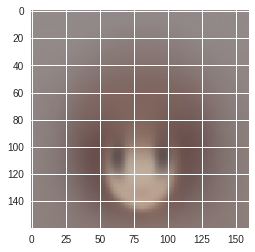

In [11]:
# 平均画像の表示
%matplotlib inline
plt.imshow(mean.transpose(1, 2, 0) / 255)
plt.show()

なんか怖いですね…

各画像から平均を引くときはピクセルごとの平均を使うので、この平均画像の平均画素値（RGB）を計算しておきます。

In [0]:
mean = mean.mean(axis=(1, 2))

## 4. モデルの定義とFine-tuningの準備

では次に、訓練を行うモデルの定義を行います。ここではたくさんの2Dイラスト画像を使って学習したモデルでタグ予測や特徴抽出などを行う[Illustration2Vec](https://github.com/rezoo/illustration2vec)で使われたネットワークをベースとし、その最後の2層を削除してランダムに初期化された2つの全結合層を付け加えたものを新しいモデルとします。

学習時には、Illustration2Vecのpre-trained weightで出力から3層目以下の部分を初期化したのち、その部分の重みは固定しておきます。つまり、**新たに追加した2つの全結合層だけを訓練します。**

まず、配布されているIllustration2Vecモデルの訓練済みパラメータをダウンロードしてきます。

In [13]:
%%bash
if [ ! -f illust2vec_ver200.caffemodel ]; then
    curl -L -O https://github.com/rezoo/illustration2vec/releases/download/v2.0.0/illust2vec_ver200.caffemodel
fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   618    0   618    0     0    618      0 --:--:-- --:--:-- --:--:--  2641
100  933M  100  933M    0     0  54.8M      0  0:00:17  0:00:17 --:--:-- 68.7M


この訓練済みパラメータはcaffemodelの形式で提供されていますが、Chainerには非常に簡単にCaffeの訓練済みモデルを読み込む機能（[`CaffeFunction`](http://docs.chainer.org/en/stable/reference/generated/chainer.links.caffe.CaffeFunction.html#chainer.links.caffe.CaffeFunction)）があるので、これを使ってパラメータとモデル構造をロードします。ただし、読み込みには時間がかかるため、一度読み込んだ際に得られる`Chain`オブジェクトをPython標準の`pickle`を使ってファイルに保存しておきます。こうすることで次回からの読み込みが速くなります。

実際のネットワークのコードは以下のようになります。

In [14]:
import dill

import chainer
import chainer.links as L
import chainer.functions as F

from chainer import Chain
from chainer.links.caffe import CaffeFunction
from chainer import serializers


class Illust2Vec(Chain):

    CAFFEMODEL_FN = 'illust2vec_ver200.caffemodel'

    def __init__(self, n_classes, unchain=True):
        w = chainer.initializers.HeNormal()        
        model = CaffeFunction(self.CAFFEMODEL_FN)  # CaffeModelを読み込んで保存します。（時間がかかります）
        del model.encode1  # メモリ節約のため不要なレイヤを削除します。
        del model.encode2
        del model.forwards['encode1']
        del model.forwards['encode2']
        model.layers = model.layers[:-2]
        
        super(Illust2Vec, self).__init__()
        with self.init_scope():
            self.trunk = model  # 元のIllust2Vecモデルをtrunkとしてこのモデルに含めます。
            self.fc7 = L.Linear(None, 4096, initialW=w)
            self.bn7 = L.BatchNormalization(4096)
            self.fc8 = L.Linear(4096, n_classes, initialW=w)
            
    def __call__(self, x):
        h = self.trunk({'data': x}, ['conv6_3'])[0]  # 元のIllust2Vecモデルのconv6_3の出力を取り出します。
        h.unchain_backward()
        h = F.dropout(F.relu(self.bn7(self.fc7(h))))  # ここ以降は新しく追加した層です。
        return self.fc8(h)


n_classes = len(dnames)
model = Illust2Vec(n_classes)
model = L.Classifier(model)

/usr/local/lib/python3.6/dist-packages/chainer/links/caffe/caffe_function.py:165: UserWarning: Skip the layer "encode1neuron", since CaffeFunction does notsupport Sigmoid layer
  'support %s layer' % (layer.name, layer.type))
/usr/local/lib/python3.6/dist-packages/chainer/links/caffe/caffe_function.py:165: UserWarning: Skip the layer "loss", since CaffeFunction does notsupport SigmoidCrossEntropyLoss layer
  'support %s layer' % (layer.name, layer.type))


`__call__`の部分に`h.unchain_backward()`という記述が登場しました。`unchain_backward`は、ネットワークのある中間出力`Variable` などから呼ばれ、その時点より前のあらゆるネットワークノードの接続を断ち切ります。そのため、学習時にはこれが呼ばれた時点より前の層に誤差が伝わらなくなり、結果としてパラメータの更新も行われなくなります。

前述の

> 学習時には、Illustration2Vecのpre-trained weightで出力から3層目以下の部分を初期化したのち、その部分の重みは固定しておきます。

これを行うためのコードが、この`h.unchain_backward()`です。

このあたりの仕組みについて、さらに詳しくは、Define-by-RunによるChainerのautogradの仕組みを説明しているこちらの記事を参照してください。: [1-file Chainerを作る](http://qiita.com/mitmul/items/37d3932292cdd560d418)

## 5. 学習

それでは、このデータセットとモデルを用いて、学習を行ってみます。まず必要なモジュールをロードしておきます。

In [0]:
from chainer import iterators
from chainer import training
from chainer import optimizers
from chainer.training import extensions
from chainer.training import triggers
from chainer.dataset import concat_examples

次に学習のパラメータを設定します。今回は

- バッチサイズ64
- 学習率は0.01からスタートし、10エポック目で0.1倍にする
- 20エポックで学習終了

とします。

In [0]:
batchsize = 64
gpu_id = 0
initial_lr = 0.01
lr_drop_epoch = 10
lr_drop_ratio = 0.1
train_epoch = 20

以下が学習を行うコードです。

In [17]:
train_iter = iterators.MultiprocessIterator(train, batchsize)
valid_iter = iterators.MultiprocessIterator(
    valid, batchsize, repeat=False, shuffle=False)

optimizer = optimizers.MomentumSGD(lr=initial_lr)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(0.0001))

updater = training.StandardUpdater(
    train_iter, optimizer, device=gpu_id)

trainer = training.Trainer(updater, (train_epoch, 'epoch'), out='AnimeFace-result')
trainer.extend(extensions.LogReport())
trainer.extend(extensions.observe_lr())

# 標準出力に書き出したい値
trainer.extend(extensions.PrintReport(
    ['epoch',
     'main/loss',
     'main/accuracy',
     'val/main/loss',
     'val/main/accuracy',
     'elapsed_time',
     'lr']))

# ロスのプロットを毎エポック自動的に保存
trainer.extend(extensions.PlotReport(
        ['main/loss',
         'val/main/loss'],
        'epoch', file_name='loss.png'))

# 精度のプロットも毎エポック自動的に保存
trainer.extend(extensions.PlotReport(
        ['main/accuracy',
         'val/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# モデルのtrainプロパティをFalseに設定してvalidationするextension
trainer.extend(extensions.Evaluator(valid_iter, model, device=gpu_id), name='val')

# 指定したエポックごとに学習率をlr_drop_ratio倍にする
trainer.extend(
    extensions.ExponentialShift('lr', lr_drop_ratio),
    trigger=(lr_drop_epoch, 'epoch'))

trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time  lr        
1           1.6095      0.620861       0.63987        0.82047            96.1141       0.01        
2           0.593773    0.827297       0.49226        0.870818           180.677       0.01        
3           0.391304    0.887003       0.486601       0.870258           265.283       0.01        
4           0.295577    0.913286       0.449954       0.88465            349.812       0.01        
5           0.243304    0.924151       0.410536       0.897956           434.388       0.01        
6           0.1943      0.941432       0.427639       0.8959             519.052       0.01        
7           0.166404    0.949814       0.437762       0.895227           603.571       0.01        
8           0.140562    0.957264       0.439521       0.899041           688.154       0.01        
9           0.11407     0.967301       0.432067       0.89919            772.744       0.01        
10

6分弱くらいで学習が終わりました。標準出力に出る途中経過は上記のような感じでした。最終的に検証用データセットに対しても90%以上のaccuracyが出せていますね。では、画像ファイルとして保存されている学習経過でのロスカーブとaccuracyのカーブを表示してみます。

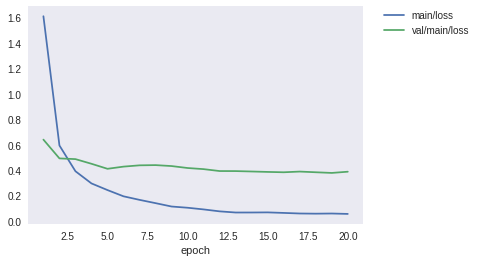

In [18]:
from IPython.display import Image
Image(filename='AnimeFace-result/loss.png')

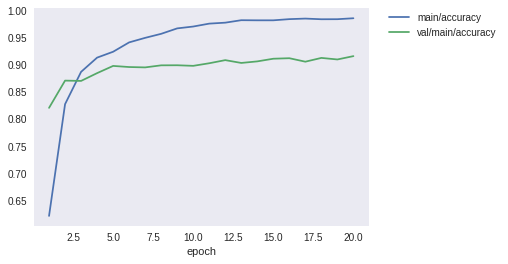

In [19]:
Image(filename='AnimeFace-result/accuracy.png')

無事収束している感じがします。

最後に、いくつかvalidationデータセットから画像を取り出してきて個別の分類結果を見てみます。

pred: 024_fujibayashi_kyou label: 024_fujibayashi_kyou True


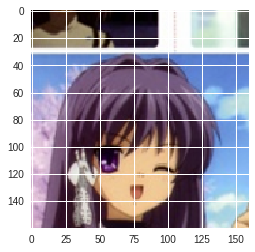

pred: 188_aika_granzchesta label: 188_aika_granzchesta True


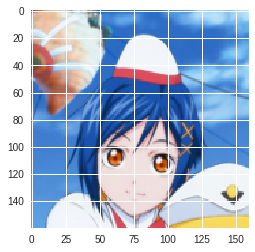

pred: 053_kousaka_tamaki label: 053_kousaka_tamaki True


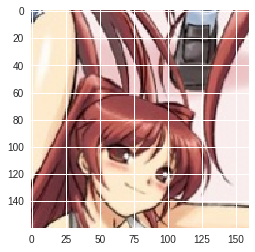

pred: 196_kikuchi_makoto label: 196_kikuchi_makoto True


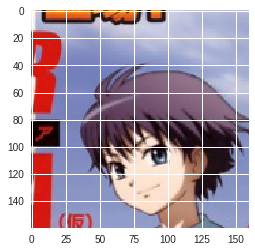

pred: 002_suzumiya_haruhi label: 002_suzumiya_haruhi True


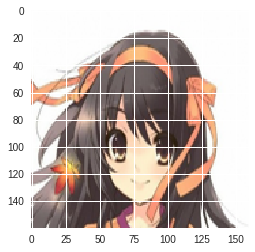

pred: 026_tohsaka_rin label: 026_tohsaka_rin True


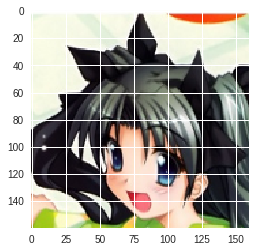

pred: 105_yuno label: 105_yuno True


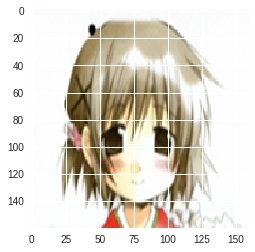

pred: 085_sonozaki_mion label: 085_sonozaki_mion True


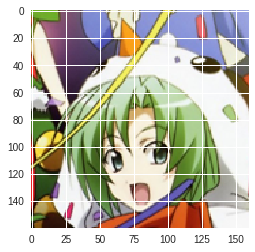

pred: 168_asagiri_mai label: 104_fukuzawa_yumi False


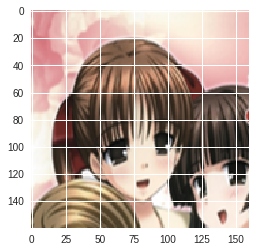

pred: 051_houjou_reika label: 051_houjou_reika True


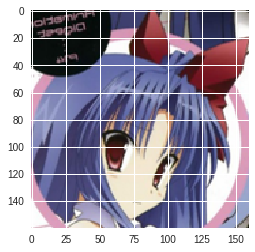

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
from chainer import cuda

chainer.config.train = False
for _ in range(10):
    x, t = valid[np.random.randint(len(valid))]
    x = cuda.to_gpu(x)
    y = F.softmax(model.predictor(x[None, ...]))
    
    pred = os.path.basename(dnames[int(y.data.argmax())])
    label = os.path.basename(dnames[t])
    
    print('pred:', pred, 'label:', label, pred == label)

    x = cuda.to_cpu(x)
    x += mean[:, None, None]
    x = x / 256
    x = np.clip(x, 0, 1)
    plt.imshow(x.transpose(1, 2, 0))
    plt.show()

ランダムに10枚選んでみたところ私の手元では全て正解できました。皆さんの場合はどうだったでしょうか。

最後に、いつか何かに使うかもしれないので、一応snapshotを保存しておきます。

In [0]:
from chainer import serializers

serializers.save_npz('animeface.model', model)

## 6. おまけ1：データセットクラスをフルスクラッチで書く方法

データセットクラスをフルスクラッチで書くには、`chainer.dataset.DatasetMixin`クラスを継承した自前クラスを用意すれば良いです。そのクラスは`__len__`メソッドと`get_example`メソッドを持つ必要があります。例えば以下のようになります。

```python
class MyDataset(chainer.dataset.DatasetMixin):
    
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
        
    def __len__(self):
        return len(self.image_paths)
    
    def get_example(self, i):
        img = Image.open(self.image_paths[i])
        img = np.asarray(img, dtype=np.float32)
        img = img.transpose(2, 0, 1)
        label = self.labels[i]
        return img, label
  ```

これは、コンストラクタに画像ファイルパスのリストと、それに対応した順番でラベルを並べたリストを渡しておき、`[]`アクセサでインデックスを指定すると、対応するパスから画像を読み込んで、ラベルと並べたタプルを返すデータセットクラスになっています。例えば、以下のように使えます。

```python
image_files = ['images/hoge_0_1.png', 'images/hoge_5_1.png', 'images/hoge_2_1.png', 'images/hoge_3_1.png', ...]
labels = [0, 5, 2, 3, ...]

dataset = MyDataset(image_files, labels)

img, label = dataset[2]

#=> 'images/hoge_2_1.png'から読み込まれた画像データと、そのラベル（ここでは2）が返る
```

このオブジェクトは、そのままIteratorに渡すことができ、Trainerを使った学習に使えます。つまり、

```python
train_iter = iterators.MultiprocessIterator(dataset, batchsize=128)
```

のようにしてイテレータを作って、UpdaterにOptimizerと一緒に渡し、そのupdaterをTrainerに渡せばTrainerを使って学習を開始できます。

## 7. おまけ2：最もシンプルなデータセットオブジェクトの作り方

実はChainerのTrainerと一緒に使うためのデータセットは、**単なるPythonのリストでOK**です。どういうことかというと、`len()`で長さが取得でき、`[]`アクセサで要素が取り出せるものなら、**全てデータセットオブジェクトとして扱う事ができる**ということです。例えば、

```python
data_list = [(x1, t1), (x2, t2), ...]
```

のような`(データ, ラベル)`というタプルのリストを作れば、これをIteratorに渡すことができます。

```python
train_iter = iterators.MultiprocessIterator(data_list, batchsize=128)
```

ただこういったやりかたの欠点は、データセット全体を学習前にメモリに載せなければいけない点です。これを防ぐために、[ImageDataset](http://docs.chainer.org/en/stable/reference/generated/chainer.datasets.ImageDataset.html#chainer.datasets.ImageDataset)と[TupleDataset](http://docs.chainer.org/en/stable/reference/generated/chainer.datasets.TupleDataset.html#chainer.datasets.TupleDataset)を組み合わせる方法や[LabaledImageDataset](http://docs.chainer.org/en/stable/reference/generated/chainer.datasets.LabeledImageDataset.html#chainer.datasets.LabeledImageDataset)といったクラスが用意されています。詳しくはドキュメントをご参照ください。
http://docs.chainer.org/en/stable/reference/datasets.html#general-datasets